In [2]:
!pip3 install gensim

You should consider upgrading via the 'C:\Users\jazmi\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


# Obtener los datos

El conjunto de datos a utilizar será sentiment140.

In [39]:
ENCODING = "ISO-8859-1"
COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

twitter_data = pd.read_csv('dataset.csv',  encoding =ENCODING , names=COLUMNS)
twitter_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Explorar los datos para obtener información

Contiene 1,600,000 tweets extraídos usando la API de Twitter. Los tweets se han anotado (0 = negativo, 2 = neutral, 4 = positivo) y se pueden utilizar para detectar sentimientos. El idioma en el que están es el inglés.

In [5]:
print("Tamaño del conjunto de datos:", len(twitter_data))

Tamaño del conjunto de datos: 1600000


El conjunto de datos contiene los siguientes 6 campos:
- target: la polaridad del tweet (0 = negativo, 2 = neutral, 4 = positivo)
- ids: la identificación del tweet 
- date: la fecha del tweet
- flag: la consulta. Si no hay ninguna consulta, este valor es NO_QUERY.
- user: el usuario que tuiteó 
- text: el texto del tweet

In [6]:
print("Información sobre el conjunto de datos \n")
print(twitter_data.info())

Información sobre el conjunto de datos 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None


<p style="font-family: Arial; font-size:1.4em;color:blue;"> Sentimientos </p>

Los sentimientos dentro del conjunto de datos se distribuye entre los valores de sentimiento positivo y negativo. En un gráfico de barras se desplegará la cantidad de tweets negativos en rojo y tweets positivos en verde.

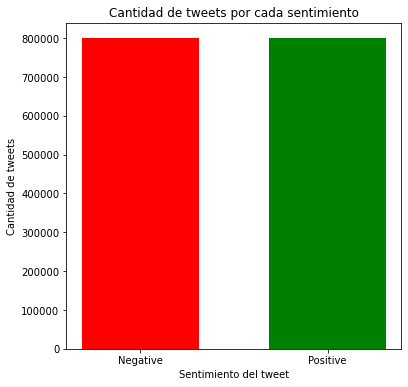

In [7]:
class_count = twitter_data['target'].value_counts()
plt.figure(figsize = (6, 6))
plt.xticks([4, 0], ['Positive', 'Negative'])
plt.xticks([4, 0])
plt.bar(x = class_count.keys(), 
        height = class_count.values, 
        color = ['g', 'r'], width = 2.5)
plt.xlabel("Sentimiento del tweet")
plt.ylabel("Cantidad de tweets")
plt.title("Cantidad de tweets por cada sentimiento")
plt.show()

El conjunto de datos se distribuye uniformemente entre tweets positivos (4) y negativos (0).

In [8]:
sentiment = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return sentiment[int(label)]

In [9]:
%%time
twitter_data.target = twitter_data.target.apply(lambda x: decode_sentiment(x))

Wall time: 546 ms


<p style="font-family: Arial; font-size:1.4em;color:blue;"> Fecha </p>

La fecha es una característica importante si se desea analizar los tweets basados en el mes de un año. Se extraerá el mes de cada tweet y en un gráfico se apreciará el recuento de tweets para cada uno de ellos.

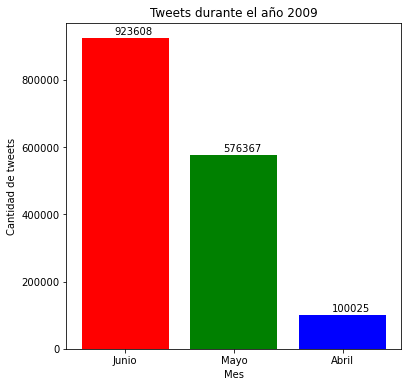

In [10]:
twitter_data['month'] = twitter_data['date'].apply(lambda date: date.split(' ')[1])
months_count = twitter_data['month'].value_counts()

plt.figure(figsize = (6,6))
plt.bar(['Junio', 'Mayo', 'Abril'], months_count.values, color = ['r', 'g', 'b'])
for i, v in enumerate(months_count.values):
    plt.text(i - 0.1, v + 10000, str(v))
plt.xlabel('Mes')
plt.ylabel('Cantidad de tweets')
plt.title('Tweets durante el año 2009')
plt.show()

En el mes de junio se capturó el mayor número de tweets, con una cantidad de 923608.

In [54]:
data = twitter_data

# Preparación de los datos

El proceso de convertir datos en algo que una computadora pueda entender se conoce como preprocesamiento. Una de las principales formas de preprocesamiento es filtrar los datos inútiles. En el procesamiento del lenguaje natural, las palabras inútiles(datos) se denominan stop words. Por lo tanto, estas deben ser eliminadas.

- Natural Language Toolkit (NLTK) es un conjunto de bibliotecas y programas para el procesamiento del lenguaje natural

In [15]:
nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jazmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<p style="font-family: Arial; font-size:1.4em;color:blue;"> Stemming </p> 

Es el proceso de reducir la palabra a su palabra base o raíz de tal manera que las palabras de tipo similar se encuentren bajo una raíz común.

Ejemplo: Word        -         Stem

- cared -         care
- fairly -        fair
- easily  -       easili
- singing  -      sing
- sings     -     sing
- sung       -    sung
- singer      -   singer
- sportingly   -  sport

Existen varios algoritmos que se pueden aplicar en este proceso:

- Snowball Stemmer: es un algoritmo de derivación que también se conoce como algoritmo de derivación de Porter2, ya que es una mejor versión de Porter Stemmer, ya que algunos problemas se solucionaron en esta derivación.

- Porter Stemmer: Este es un antiguo algoritmo de derivación que fue desarrollado por Martin Porter en 1980. En comparación con otros algoritmos, es un algoritmo de derivación muy suave.

- Lancaster Stemmer: es el algoritmo de derivación más agresivo. También podemos agregar nuestras propias reglas personalizadas en este algoritmo cuando lo implementamos usando el paquete NLTK. Dado que es agresivo, a veces también puede dar como resultado raíces extrañas.

Para este trabajo se optó por utilizar Snowball Stemmer.


In [24]:
stemmer = SnowballStemmer("english")

In [25]:
# Expresión regular para eliminar el usuario, el enlace (https o http) y los caracteres especiales
TEXT_CLEANING = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [63]:
s1 = data.loc[data['ids'] == 2051457557]['text']
print(s1)

1374558    @jbtaylor WIth ya. &quot;I'd like a Palm Pre, ...
Name: text, dtype: object


In [26]:
%%time
data.text = data.text.apply(lambda x: preprocess(x))

Wall time: 50.4 s


El conjunto de datos se dividirá en 80% de los datos para el entrenamiento y el 20% restante para las pruebas. 

In [27]:
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", len(df_train))
print("Tamaño del conjunto de pruebas:", len(df_test))

Tamaño del conjunto de entrenamiento: 1280000
Tamaño del conjunto de pruebas: 320000


In [41]:
df_train.head()

,target,ids,date,flag,user,text,month
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...,Jun
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter,Jun
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey,May
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...,Jun
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view,May


In [28]:
%%time
documents = [_text.split() for _text in df_train.text] 
print(documents[0])

['ya', 'quot', 'like', 'palm', 'pre', 'touchstone', 'charger', 'readynow', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch']
Wall time: 5.58 s


<p style="font-family: Arial; font-size:1.4em;color:blue;"> Word2Vec </p> 

Word2Vec fue presentado en dos artículos entre septiembre y octubre de 2013, por un equipo de investigadores de Google. Junto con los artículos, los investigadores publicaron su implementación en C. La implementación de Python se realizó poco después del primer artículo, por Gensim.

La suposición subyacente de Word2Vec es que dos palabras que comparten contextos similares también comparten un significado similar y, en consecuencia, una representación vectorial similar del modelo. Por ejemplo: "perro", "cachorro" y "cachorro" se usan a menudo en situaciones similares, con palabras circundantes similares como "bueno", "esponjoso" o "lindo", y de acuerdo con Word2Vec, por lo tanto, compartirán una representación vectorial similar.

A partir de esta suposición, Word2Vec se puede usar para averiguar las relaciones entre palabras en un conjunto de datos, calcular la similitud entre ellas o usar la representación vectorial de esas palabras como entrada para otras aplicaciones, como clasificación de texto o agrupamiento.

Parámetros del Modelo:
- min_count = int - Ignora todas las palabras con una frecuencia absoluta total menor que esta - (2, 100)
- window = int: la distancia máxima entre la palabra actual y la predicha dentro de una oración. P.ej. palabras de ventana a la izquierda y palabras de ventana a la izquierda de nuestro objetivo - (2, 10)
- size = int - Dimensionalidad de los vectores de características. - (50, 300)
- sample = float: el umbral para configurar qué palabras de mayor frecuencia se reducen aleatoriamente. Altamente influyente. - (0, 1e-5)
- alpha = float - La tasa de aprendizaje inicial - (0.01, 0.05)
- min_alpha = float: la tasa de aprendizaje descenderá linealmente a min_alpha a medida que avanza el entrenamiento. Para configurarlo: alpha - (min_alpha * epochs) ~ 0.00
- negativo = int - Si> 0, se usará un muestreo negativo, el int para negativo especifica cuántas "palabras irrelevantes" deben ahogarse. Si se establece en 0, no se utiliza ningún muestreo negativo. - (5, 20)
- workers = int: número de threads de trabajo para entrenar el modelo (= entrenamiento más rápido con máquinas multinúcleo)

In [14]:
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

w2v_model = gensim.models.word2vec.Word2Vec(min_count=W2V_MIN_COUNT, 
                                            window=W2V_WINDOW, 
                                            size=W2V_SIZE, 
                                            workers=8)

Aquí construye el vocabulario a partir de una secuencia de oraciones y así inicializa el modelo.
Con los registros, puedo seguir el progreso y aún más importante, el efecto de min_count y sample en el corpus de palabras. Noté que estos dos parámetros, y en particular la muestra, tienen una gran influencia sobre el rendimiento de un modelo. La visualización de ambos permite una gestión más precisa y sencilla de su influencia.

In [64]:
w2v_model.build_vocab(documents)

2020-12-15 18:13:36,991 : INFO : collecting all words and their counts
2020-12-15 18:13:36,993 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-15 18:13:37,019 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2020-12-15 18:13:37,040 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2020-12-15 18:13:37,062 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2020-12-15 18:13:37,085 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2020-12-15 18:13:37,107 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2020-12-15 18:13:37,127 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2020-12-15 18:13:37,151 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2020-12-15 18:13:37,174 : INFO : PROGRESS: at s

2020-12-15 18:13:38,804 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2020-12-15 18:13:38,830 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2020-12-15 18:13:38,855 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2020-12-15 18:13:38,880 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2020-12-15 18:13:38,907 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2020-12-15 18:13:38,935 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2020-12-15 18:13:38,961 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2020-12-15 18:13:38,988 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2020-12-15 18:13:39,013 : INFO : PROGRESS: at sentence #800000, processed 577088

In [65]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Tamaño del vocabulario: ", vocab_size)

Tamaño del vocabulario:  30369


Entrenar el modelo

Parámetros del Entrenamiento del Modelo:
- total_examples = int - Recuento de oraciones
- epochs = int - Número de iteraciones (épocas) sobre el corpus

In [19]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-12-10 20:25:53,520 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-10 20:25:54,571 : INFO : EPOCH 1 - PROGRESS: at 13.79% examples, 1121911 words/s, in_qsize 16, out_qsize 1
2020-12-10 20:25:55,574 : INFO : EPOCH 1 - PROGRESS: at 28.07% examples, 1147678 words/s, in_qsize 15, out_qsize 0
2020-12-10 20:25:56,590 : INFO : EPOCH 1 - PROGRESS: at 41.91% examples, 1138956 words/s, in_qsize 16, out_qsize 1
2020-12-10 20:25:57,592 : INFO : EPOCH 1 - PROGRESS: at 55.32% examples, 1130063 words/s, in_qsize 15, out_qsize 0
2020-12-10 20:25:58,602 : INFO : EPOCH 1 - PROGRESS: at 69.50% examples, 1135073 words/s, in_qsize 15, out_qsize 0
2020-12-10 20:25:59,627 : INFO : EPOCH 1 - PROGRESS: at 83.18% examples, 1128447 words/s, in_qsize 16, out_qsize 1
2020-12-10 20:26:00,638 : INFO : EPOCH 1 - PROGRESS: at 97.39% examples, 1131859 words/s, in_qsize 14, out_qsize 1
2020-12-10 20:26:00,753 : INFO : worker threa

Wall time: 3min 53s


(263125543, 295270528)

In [20]:
w2v_model.most_similar("love")

<ipython-input-20-9e1a4c826e7b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2020-12-10 20:29:46,745 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5687564015388489),
 ('loves', 0.5656490325927734),
 ('loved', 0.5201522707939148),
 ('looove', 0.5159773826599121),
 ('amazing', 0.5081393122673035),
 ('adore', 0.5033565759658813),
 ('awesome', 0.46679264307022095),
 ('loveee', 0.4652930200099945),
 ('lovee', 0.4582024812698364),
 ('miss', 0.43126583099365234)]

<p style="font-family: Arial; font-size:1.4em;color:blue;"> Tokenizar el texto </p> 

- Función fit_on_texts : Actualiza el vocabulario interno basado en una lista de textos. 
En el caso de que los textos contengan listas, asumimos que cada entrada de las listas es un token.
Es requirido antes de usar texts_to_sequences o texts_to_matrix.

In [69]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

print("Total de palabras: ", vocab_size)

Total de palabras:  290419
Wall time: 16.3 s


- Función texts_to_sequences: Transforma cada texto en textos en una secuencia de números enteros.
Solo se tendrán en cuenta las primeras num_words-1 palabras más frecuentes. Solo se tendrán en cuenta las palabras conocidas por el tokenizador.

- Función pad_sequences : Esta función transforma una lista (de longitud num_samples) de secuencias (listas de enteros) en una matriz Numpy 2D de forma (num_samples, num_timesteps). num_timesteps es el argumento maxlen si se proporciona, o la longitud de la secuencia más larga de la lista.
Las secuencias que son más cortas que num_timesteps se rellenan con valor hasta que tengan una longitud de num_timesteps.
Las secuencias de más de num_timesteps se truncan para que se ajusten a la longitud deseada.

In [22]:
%%time
SEQUENCE_LENGTH = 300
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 24.4 s


In [71]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

Embedding layer

Ejemplo:
Nuestro conjunto de entrenamiento consta solo de dos frases:

- Hope to see you soon
- Nice to see you again

Entonces, podemos codificar estas frases asignando a cada palabra un número entero único (por orden de aparición en nuestro conjunto de datos de entrenamiento, por ejemplo). Entonces nuestras frases podrían reescribirse como:   
- [0, 1, 2, 3, 4]

- [5, 1, 2, 3, 6]

Ahora imagine que queremos entrenar una red cuya primera capa es una embedding layer. En este caso, debemos inicializarlo de la siguiente manera:

- Embedding(7, 2, input_length=5)

El primer argumento (7) es el número de palabras distintas en el conjunto de entrenamiento. El segundo argumento (2) indica el tamaño de los vectores de embedding. El argumento input_length, por supuesto, determina el tamaño de cada secuencia de entrada.

Una vez que se ha entrenado la red, podemos obtener los pesos de la capa de embedding, que en este caso será de tamaño (7, 2) y se puede pensar como la tabla utilizada para mapear enteros a vectores de embedding:

+------------+------------+

|   index    |  Embedding |

+------------+------------+

|     0      | [1.2, 3.1] |

|     1      | [0.1, 4.2] |

|     2      | [1.0, 3.1] |

|     3      | [0.3, 2.1] |

|     4      | [2.2, 1.4] |

|     5      | [0.7, 1.7] |

|     6      | [4.1, 2.0] |

+------------+------------+


In [27]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


Convierte números enteros positivos (índices) en vectores densos de tamaño fijo.
Esta capa solo se puede utilizar como primera capa en un modelo.

In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Construir el modelo

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


Compilar el modelo

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Callbacks

En Keras 'Callback' es una clase de python destinada a ser subclase para proporcionar una funcionalidad específica, con un conjunto de métodos llamados en varias etapas de entrenamiento (incluyendo el inicio y fin de los batch/epoch), pruebas y predicciones. Los Callbacks son útiles para tener visibilidad de los estados internos y las estadísticas del modelo durante el entrenamiento. 

In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

Entrenamiento

In [32]:
EPOCHS = 5
BATCH_SIZE = 1024

%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/5
1152000/1152000 [==============================] - 5626s 5ms/step - loss: 0.5076 - accuracy: 0.7477 - val_loss: 0.4688 - val_accuracy: 0.7781
Epoch 2/5


C:\Users\jazmi\AppData\Roaming\Python\Python38\site-packages\keras\callbacks\callbacks.py:843: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  warnings.warn(


1152000/1152000 [==============================] - 6059s 5ms/step - loss: 0.4823 - accuracy: 0.7649 - val_loss: 0.4574 - val_accuracy: 0.7839
Epoch 3/5
1152000/1152000 [==============================] - 7069s 6ms/step - loss: 0.4755 - accuracy: 0.7695 - val_loss: 0.4563 - val_accuracy: 0.7854
Epoch 4/5
1152000/1152000 [==============================] - 5710s 5ms/step - loss: 0.4730 - accuracy: 0.7709 - val_loss: 0.4500 - val_accuracy: 0.7870
Epoch 5/5
1152000/1152000 [==============================] - 5740s 5ms/step - loss: 0.4696 - accuracy: 0.7734 - val_loss: 0.4500 - val_accuracy: 0.7882
Wall time: 8h 23min 24s


Evaluar

In [33]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 369s 1ms/step

ACCURACY: 0.7883594036102295
LOSS: 0.44861537132263185
Wall time: 6min 9s


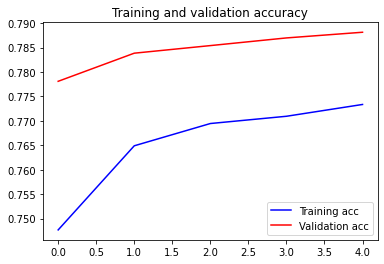

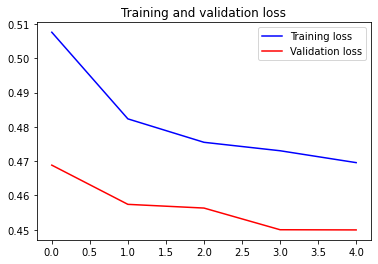

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predecir

In [41]:
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [42]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [43]:
predict("I love the music")

{'label': 'POSITIVE',
 'score': 0.9755492806434631,
 'elapsed_time': 0.28643202781677246}

In [44]:
predict("I hate the rain")

{'label': 'NEGATIVE',
 'score': 0.011914847418665886,
 'elapsed_time': 0.02089524269104004}

In [45]:
predict("i don't know what i'm doing")

{'label': 'NEGATIVE',
 'score': 0.2864530384540558,
 'elapsed_time': 0.019969940185546875}

Métricas

In [46]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 383s 1ms/step
Wall time: 6min 23s


In [47]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

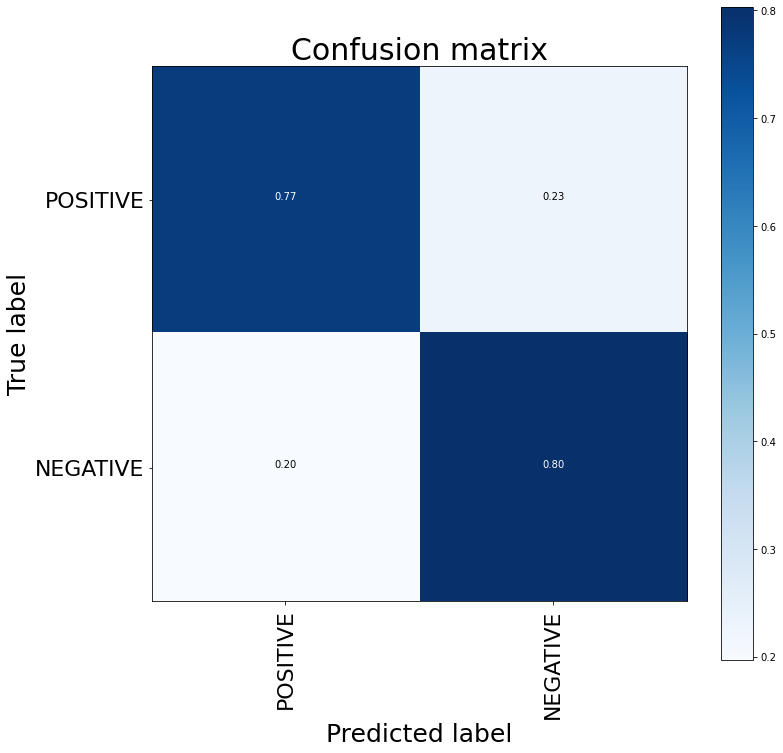

Wall time: 1.11 s


In [48]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [49]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.77      0.78    159494
    POSITIVE       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [50]:
accuracy_score(y_test_1d, y_pred_1d)

0.788359375

In [51]:
model.save("model.h5")
w2v_model.save("model.w2v")
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("encoder.pkl", "wb"), protocol=0)

2020-12-11 06:49:20,990 : INFO : saving Word2Vec object under model.w2v, separately None
2020-12-11 06:49:20,992 : INFO : not storing attribute vectors_norm
2020-12-11 06:49:20,992 : INFO : not storing attribute cum_table
2020-12-11 06:49:21,851 : INFO : saved model.w2v
